# Fake news detection with sentiment analysis

In this project, I analyze articles with FastText and XGBoost.

The goal is to create a model, which will be able to classify a specific article as a fake news or a legitimite one.

In [45]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
import io
from sklearn.metrics import confusion_matrix

In [2]:
import gensim.models.wrappers.fasttext
import nltk
import re
import seaborn as sns
import matplotlib.pyplot as plt

## Data preproocessing

First, we need to get our dataset. I choose a dataset from Kaggle. You can find it on https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset

In [3]:
import pandas as pd
import numpy as np

In [4]:
df =  pd.read_csv("data.csv")

In [5]:
df.head()

,Unnamed: 0,title,content,label
0,0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",0
1,1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,0
2,2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,1
3,3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0
4,4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,1


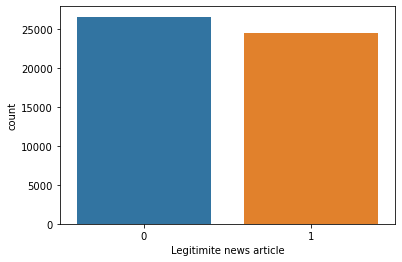

In [6]:
sns.countplot(df.label)
plt.xlabel('Legitimite news article');

We can see that our dataset is balanced. That means that we can continue and vectorize the content of the articles.

## Text vectorization

For the vectorization, we are going to use a pretrained FastText model. You can get it from https://fasttext.cc/docs/en/english-vectors.html

First, we load up a list of english stopwords. I got mine from https://www.ranks.nl/stopwords 


In [7]:
with open("stopwords.txt") as f:
    stopwords = f.read().splitlines()

In [8]:
ft_model = gensim.models.KeyedVectors.load_word2vec_format('model/crawl-300d-2M.vec', binary=False, encoding='utf8')

In [9]:
def get_vector_representation(title, content):
    tokens=nltk.word_tokenize(re.sub(r'\W', ' ', str(title)+". "+str(content)))
    tokens=[token for token in tokens if token not in stopwords and token in ft_model]

    return np.mean([ft_model[token]for token in tokens[:20]],axis=0)

We represent each article by a specific vector. We combine the title and the content of the article and then tokenize them. We select the first 20 vectors, get their representations from the FastText model. After that, we just average them out and we have a good representation of the text.

In [10]:
df["vector_representation"]=df.apply(lambda x:get_vector_representation(x["title"],x["content"]),axis=1)

Here we convert the vector representation column of arrays to its own columns as is required by the scikit API.

In [22]:
df=pd.concat([df["vector_representation"].apply(pd.Series), df.drop("vector_representation",axis=1)], axis = 1)

In [27]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,293,294,295,296,297,298,299,title,content,label
0,0.064415,0.033875,-0.141095,-0.011245,-0.004780,0.045480,0.200275,-0.003515,-0.051690,0.011305,...,-0.108185,0.080955,0.097565,-0.106220,0.075310,-0.023730,-0.039235,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",0
1,0.164210,-0.093245,-0.111780,0.022280,-0.062470,0.054950,0.260145,-0.075530,-0.174785,0.078090,...,-0.176425,0.135420,0.156090,-0.054970,0.034985,0.039445,-0.009555,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,0
2,0.255170,0.067750,-0.223975,-0.058440,0.051825,0.072170,0.024450,0.038905,-0.077105,0.026810,...,-0.013060,-0.095835,0.044540,-0.037535,0.002690,-0.151465,-0.003710,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,1
3,0.211275,-0.185575,-0.000015,-0.022460,0.006010,-0.045835,0.050285,-0.005650,-0.036935,0.018705,...,-0.144520,0.004925,0.024545,-0.005720,0.014530,-0.005965,-0.042520,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0
4,0.254485,0.027200,-0.136570,-0.014175,0.004620,0.090940,0.105010,-0.010025,0.034690,0.023520,...,-0.211220,0.057645,0.055110,-0.049080,0.058735,0.028715,-0.032510,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,1


In [38]:
classifier=XGBClassifier()

We split the dataframe into targets and features, while dropping all nonnumerical columns.

In [60]:
X=df.drop(["title","content","label"],axis=1)
y=df["label"]

In [61]:
scores=cross_val_score(classifier,X,y,cv=5)

[13:03:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:04:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:04:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:04:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

## Evaluation

In [62]:
scores.mean()

0.978607573112004

We can see that the mean of the cross validation is about 97.9%. That means that our model is not overfitting and generalizes well. We can continue with the evaluation.

In [64]:
predicted=classifier.predict(X)

Text(0.5, 15.0, 'Predicted sentiment')

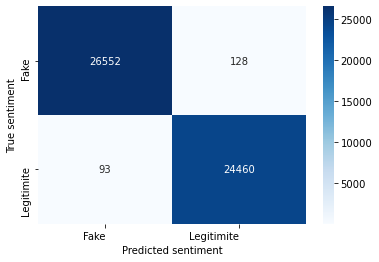

In [67]:
cm = confusion_matrix(predicted, y)
df_cm = pd.DataFrame(cm, index=["Fake","Legitimite"], columns=["Fake","Legitimite"])

hmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), ha='right')
plt.ylabel('True sentiment')
plt.xlabel('Predicted sentiment')

## Conclusion

In the confusion matrix, we are able to see that our model evalues most of the articles correctly. However, about 2 percent were incorrect and split equally between false positives and true negatives.

I think that if we wanted to create a more precise classifier, we would need to use a different model, which will take into account the articles as a whole. In situation, when misinformation is only once mention in an article, FastText won't be able to detect it as well. I could suggest using Electra or BERT.

However, I still believe a 98 percent accuracy is impressive and it is a lot more than I expected when I started the project.